# Assignment: Clustering SST Data

1. Cluster the raw (weighted) SST data, found in `test.nc`. Use the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to find ways to find the optimal number of clusters and use it to find optimal number of clusters. Describe the cluster centers that you obtain.
2. Cluster the (weighted) zero mean anomalies and find optimal clusters. Describe the cluster centers.

---------------------------------------

## 1. Weighting and setting up the data:

I have `PyPI`-installed the following packages additionally to what I locally have on my machine: xarray, scipy, scikit-learn, nc-time-axis, eofs.

Importing necessary packages into this notebook:

In [1]:
import numpy as np
import xarray
import matplotlib.pyplot as plt

Reading the raw SST dataset file saved locally as `test.nc`:

In [2]:
complete_SST = xarray.open_dataset('test.nc', engine='scipy').sst
# READING THE XARRAY FILE

The SST data can be looked at in two ways, one is spatially and the other is temporally. The below cosine-weighting is done so that for each point in time, the corresponding monthly mean is subtracted from it.
The clustering is done spatially, with the time series of each coordinate, marked by (lat,lon), being used as the vector for the clustering procedure.

The SST data is monthly mean, as was mentioned. So, there is exactly one Temperature '2D-matrix' associated with each time point, which is a month. This data is for months spanning from about 1870 to 2000. Going with what the original notebook provided did, I shall also work with all data after the 1000th time-step (month since 1870), starting somewhere around 1953.

In [3]:
raw_selected_SST = complete_SST[1000::, :].load()
# SELECTED SUBSET OF DATA THAT IS MORE RELIABLE - POST THE 1000TH MONTH

raw_selected_SST_monthly_means = raw_selected_SST.groupby('time.month').mean()
# MONTHLY MEAN FOR EVERY MONTH OVER THE SELECTED YEARS

# WE SUBSTRACT THE CORRESPONDING MONTHLY MEAN SST FROM EACH DATAPOINT
# THIS WILL GIVE US THE 'MONTHLY ANOMALIES' ACROSS ALL DATAPOINTS, AS DEFINED BELOW
anomalies = raw_selected_SST.groupby('time.month') - raw_selected_SST_monthly_means

### 1.1 Cosine-Weighting both the SSTs and the Anomalies:

Cosine-weighting is usually done in Climate Science datasets to remove the bias caused due to Median Convergence. 

Doing this gives us our two sets of data, namely the weighted zero-mean anomalies, and the weighted raw-SSTs.

In [4]:
cosines_of_latitudes = np.cos(np.deg2rad(raw_selected_SST.coords['lat'].values))
# 1D ARRAY OF THE COSINES OF ALL LATITUDES FROM -88 TO 88 DEGREES, STEP_SIZE=2
latitude_weights = np.tile(cosines_of_latitudes, (len(complete_SST.lon), 1)).transpose()
# 2D MATRIX CONSTRUCTED BY TILING THE 1D ARRAY FOR EACH LONGITUDE
weights = np.tile(latitude_weights, (len(raw_selected_SST.time), 1, 1))
# COSINE WEIGHTS FOR THE DATASET CONSTRUCTED BY TILING THE ABOVE 2D MATRIX FOR EACH TIMEPOINT

weighted_zero_mean_anomalies = anomalies - (anomalies*weights).mean(dim=['lat', 'lon'])
'''COSINE-WEIGHTED TIME-ANOMALIES'''
weighted_SST = raw_selected_SST*weights
'''COSINE-WEIGHTED RAW DATA'''

SST_with_nan = weighted_SST[0,:,:]
# GENERATING THIS SEPARATELY - USEFUL LATER FOR REINTRODUCING NaN VALUES POST-CLUSTERING

The two datasets that we then have to cluster are:
1. `weighted_SST`
2. `weighted_zero_mean_anomalies`
----------------------

# 2. Clustering:

Importing relevant modules from the scikit-learn library:

In [5]:
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import calinski_harabasz_score

### 2.1 Replacing NaN values in the SST Dataset:

We firstly have to however replace the NaN values from our data in order for us to plug the dataset into the clustering algorithm from scikit-learn and obtain a sensible output, and we shall do this by replacing each NaN value with '-1000', which is very unlikely to be any one of the SSTs and will therefore all form their own cluster. 

In [6]:
imputer = SimpleImputer(missing_values=np.nan,strategy="constant",fill_value=-1000)
# FUNCTION FROM SCIKIT-LEARN THAT IS USED TO FILL IN MISSING VALUES IN DATASETS

for i in range(572):
# REPLACING THE NULL VALUES FOR ONE TIME-STAMP AT A TIME
    weighted_SST[i,:,:] = imputer.fit_transform(weighted_SST[i,:,:])
    # REPLACING NANS WITH -1000 FOR THE SST VALUES
    weighted_zero_mean_anomalies[i,:,:] = imputer.fit_transform(weighted_zero_mean_anomalies[i,:,:])
    # REPLACING NANS WITH -1000 FOR THE ANOMALIEWS

## 3. K-Means Clustering the raw SST Data:

Now that we have our data ready as a (lat*lon) matrix of time-series vectors, we can proceed with clustering.

We define our number of clusters to be a variable, as given below. Our initialisation method for the KMeans function from scikit-learn is K-Means++

We stack our data into a singular array of time-series vectors, perform the clustering, and then unstack them into the 2-Dimensional latitude versus longitude representation.

In [7]:
stacked_SST = weighted_SST.stack(points=('lat', 'lon'))
# 'STACKING' THE DATASET INTO A 2X2 MATRIX OF LOCATION VERSUS TIME-SERIES
reshaped_SST = stacked_SST.transpose('points', 'time').values
# TAKING THE TRANSPOSE OF THE STACKED MATRIX - THIS IS WHAT WE WILL USE FOR CLUSTERING

number_of_clusters = 6
'''NUMBER OF CLUSTERS CHOSEN FOR THE RAW SST'''
kmeans_model = KMeans(n_clusters=number_of_clusters, init='k-means++').fit(reshaped_SST)
# PERFORMING THE CLUSTERING; USING K-MEANS++ AS THE INITIALISATION METHOD
cluster_labels = kmeans_model.fit_predict(reshaped_SST)
# OBTAINING THE CLUSTER LABELS POST-CLUSTERING

clustered_SST = xarray.DataArray(cluster_labels, dims=['points'], coords={'points': stacked_SST.points})
clustered_SST_2D = clustered_SST.unstack('points')
# UNSTACKING THE DATASET POST-CLUSTERING INTO A 2D-MATRIX OF LATITUDES VERSUS LONGITUDES

### 3.1 Reintroducing NaN values and creating the Contour Plot:

The variable `clustered_SST_2D` holds a matrix of latitudes versys longitudes with each entry being the cluster that that coordinate belongs to. We simply plot this data using Matplotlib and save it as a contour plot.

But before that, we reintroduce the NaN values into the array. 
(Note that the NaN values will form their own cluster when plotted)

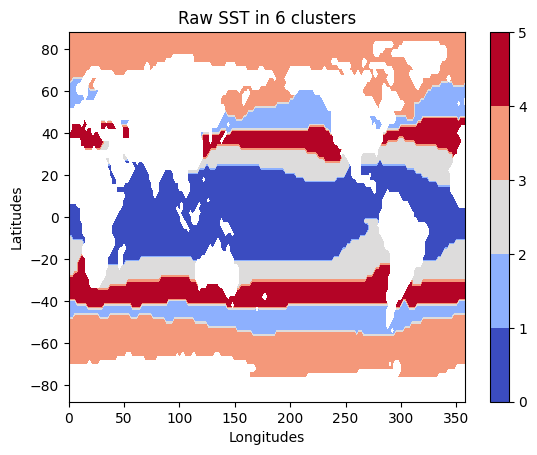

In [8]:
%matplotlib inline
plt.clf()

clustered_SST_2D = clustered_SST_2D.astype(float)
for lat in range(89):
    for lon in range(180): 
        if SST_with_nan[lat,lon]==-1000:
            clustered_SST_2D.values[lat,lon] = np.NaN
'''REINTRODUCING NAN VALUES BY COMPARING THE DATA WITH A SLICE FROM THE EARLIER SELECTED DATASET'''

cs = clustered_SST_2D.plot.contourf(cmap="coolwarm",levels=number_of_clusters+1)
'''PLOTTING THE CLUSTERS FOR THE RAW SST DATA; 
NOTE THAT THE REINTRODUCED NAN VALUES FOR LAND FORM ONE OF THE CLUSTERS!'''
plt.title(f"Raw SST in {number_of_clusters} clusters")
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
plt.grid(False)
plt.show()

### 3.2 Finding the best K using the Calinski-Harabasz metric with the help of the yellowbrick library:

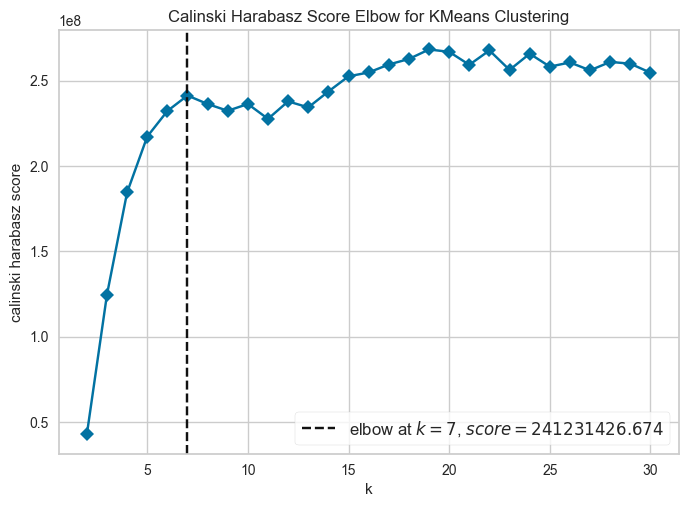

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [9]:
from yellowbrick.cluster import KElbowVisualizer
%matplotlib inline
plt.clf()

# CREATING THE KELBOWVISUALISER WITH METRIC USED BEING CALINSKI-HARABASZ
visualizer = KElbowVisualizer(kmeans_model, k=(2, 31), metric='calinski_harabasz', timings=False)
visualizer.fit(reshaped_SST)
visualizer.show()
# CREATING AND DISPLAYING THE ELBOW PLOT

### 3.3 Silhouette Analysis of the raw SST Data:
This is done for the number_of_clusters chosen to make the plot right above, and the corresponding Silhouette Analysis plot is plotted below.

Silhouette score for 5 sea clusters: 0.5912407789294966


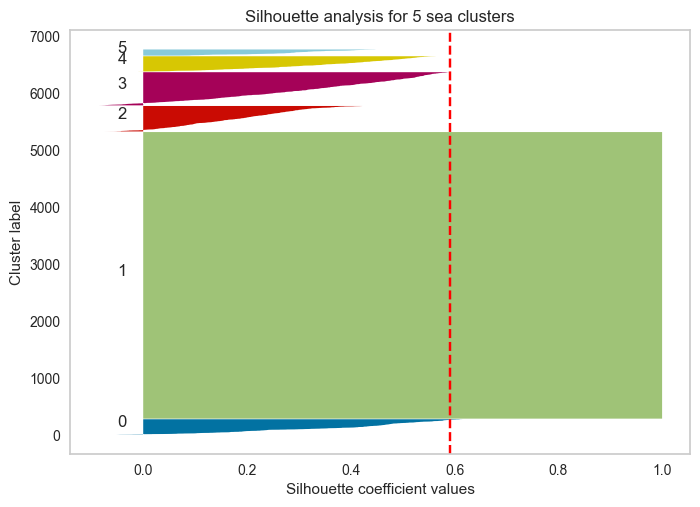

In [10]:
%matplotlib inline
plt.clf()

kmeans_model = kmeans_model.fit(reshaped_SST)
labels = kmeans_model.labels_
# EXTRACTING THE LABELS FROM THE CLUSTERED DATA

silhouette_avg = silhouette_score(reshaped_SST, labels)
# CALCULATING THE SILHOUETTE SCORE FOR THE GIVEN NUMBER_OF_CLUSTERS
print(f"Silhouette score for {number_of_clusters-1} sea clusters: {silhouette_avg}")
# RETURNING THE SILHOUETTE SCORE CORRESPONDING TO THE NUMBER OF CLUSTERS 

sample_silhouette_values = silhouette_samples(reshaped_SST, labels)
# SILHOUETTE SCORES CALCULATED FOR EACH SAMPLE

'''BELOW CODE IS TO GENERATE THE PLOT FOR THE SILHOUETTE ANALYSIS OF THE RESULTING CLUSTERS'''
y_lower = 10
for i in range(number_of_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10 

plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster label")
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
# A RED VERTICAL LINE TO MARK THE AVERAGE SILHOUETTE SCORE ON THE SILHOUETTE ANALYSIS PLOT FOR THE RAW SST DATA
plt.title(f"Silhouette analysis for {number_of_clusters-1} sea clusters")
plt.grid(False)
plt.show()

--------------
Now, we simply repeat the entire procedure for clustering the Anomalies.

-------------

# 4. Clustering the weighted zero mean anomalies:

In [11]:
stacked_anomalies = weighted_zero_mean_anomalies.stack(points=('lat', 'lon'))
# 'STACKING' THE ANOMALIES INTO A 2X2 MATRIX OF LOCATION VERSUS TIME-SERIES
reshaped_anomalies = stacked_anomalies.transpose('points', 'time').values
# TRANSPOSE OF THE STACKED MATRIX OF THE ANOMALIES

number_of_clusters = 3
'''NUMBER OF CLUSTERS CHOSEN FOR THE WEIGHTED ZERO-MEAN ANOMALIES'''
anomalies_kmeans_model = KMeans(n_clusters=number_of_clusters, init='k-means++').fit(reshaped_anomalies)
# CLUSTERING; K-MEANS++ FOR INITIALISATION
anomalies_cluster_labels = anomalies_kmeans_model.fit_predict(reshaped_anomalies)
# OBTAINING THE CLUSTER LABELS POST-CLUSTERING

clustered_anomalies = xarray.DataArray(anomalies_cluster_labels, dims=['points'], coords={'points': stacked_anomalies.points})
clustered_anomalies_2D = clustered_anomalies.unstack('points')
# UNSTACKING THE ANOMALIES POST-CLUSTERING INTO A 2D-MATRIX OF LATITUDES VERSUS LONGITUDES

### 4.1 Reintroducing NaN values and Contour Plotting:

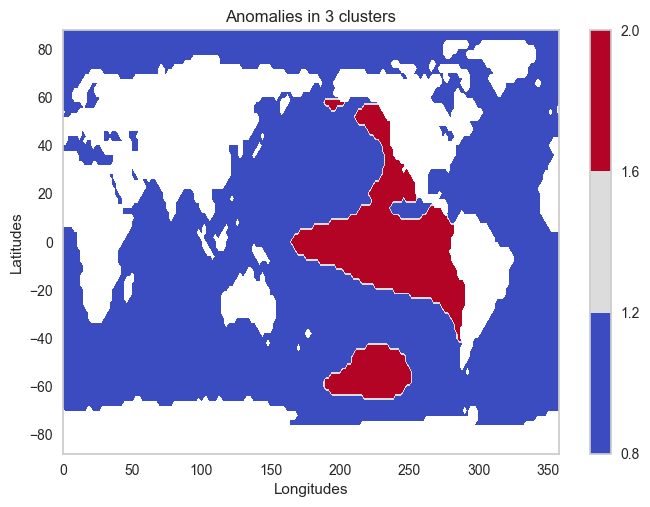

In [12]:
%matplotlib inline
plt.clf()

clustered_anomalies_2D = clustered_anomalies_2D.astype(float)
for lat in range(89):
    for lon in range(180): 
        if SST_with_nan[lat,lon]==-1000:
            clustered_anomalies_2D.values[lat,lon] = np.NaN
'''REINTRODUCING NAN VALUES BY COMPARING THE DATA WITH A SLICE FROM THE EARLIER SELECTED DATASET'''

cs = clustered_anomalies_2D.plot.contourf(cmap="coolwarm",levels=number_of_clusters+1)
'''AGAIN PLOTTING THE CLUSTERS FOR ANOMALIES'''
plt.title(f"Anomalies in {number_of_clusters} clusters")
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
plt.grid(False)
plt.show()

### 4.2 Finding the best K using the Calinski-Harabasz metric with the help of the yellowbrick library:

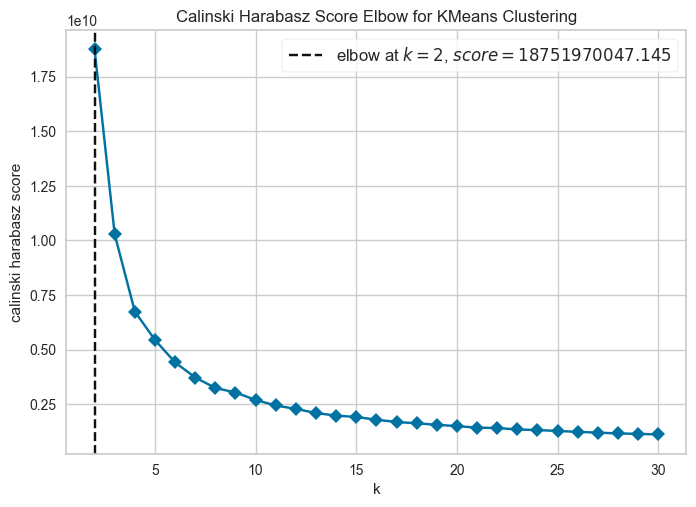

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [13]:
from yellowbrick.cluster import KElbowVisualizer
%matplotlib inline
plt.clf()

# CREATING THE KELBOWVISUALISER WITH METRIC USED BEING CALINSKI-HARABASZ
visualizer = KElbowVisualizer(anomalies_kmeans_model, k=(2, 31), metric='calinski_harabasz', timings=False)
visualizer.fit(reshaped_anomalies)
visualizer.show()
# CREATING AND DISPLAYING THE ELBOW PLOT